Starting comprehensive MNIST dimensionality reduction analysis...
Loading MNIST dataset...
Data loaded: 8000 training samples, 2000 test samples
Original dimensions: 784

1. Standard PCA (2D visualization)...


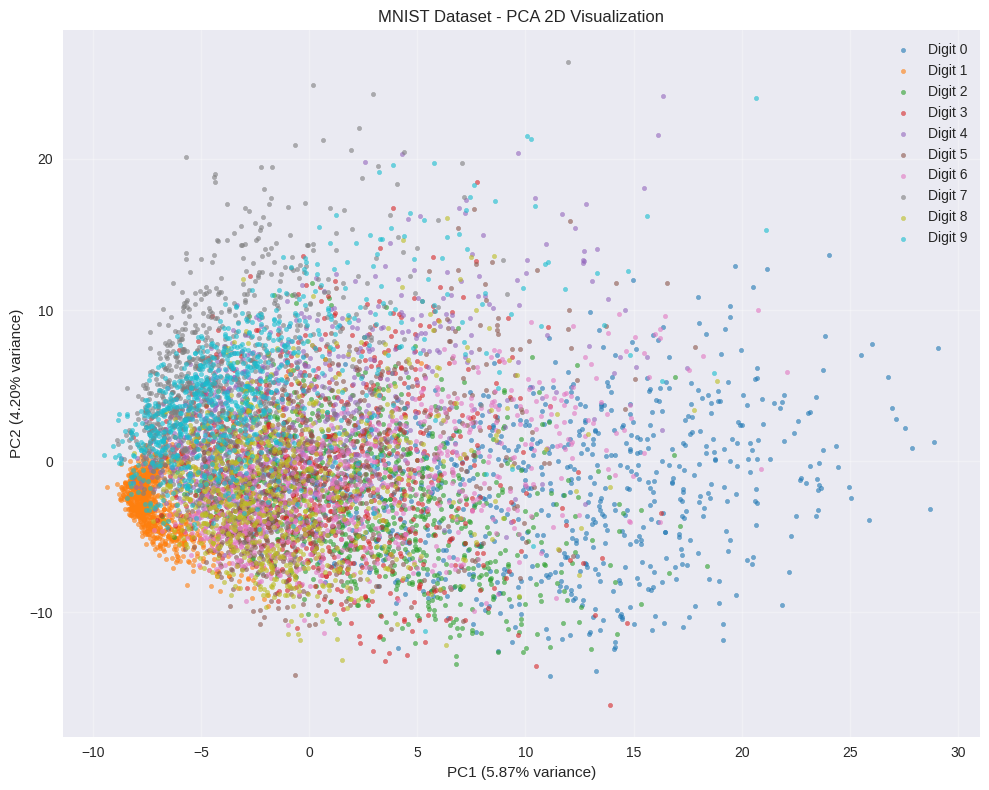

Explained variance ratio: [0.05865934 0.0420226 ]
Total variance explained: 10.07%

2. Finding optimal number of components for 95% variance...


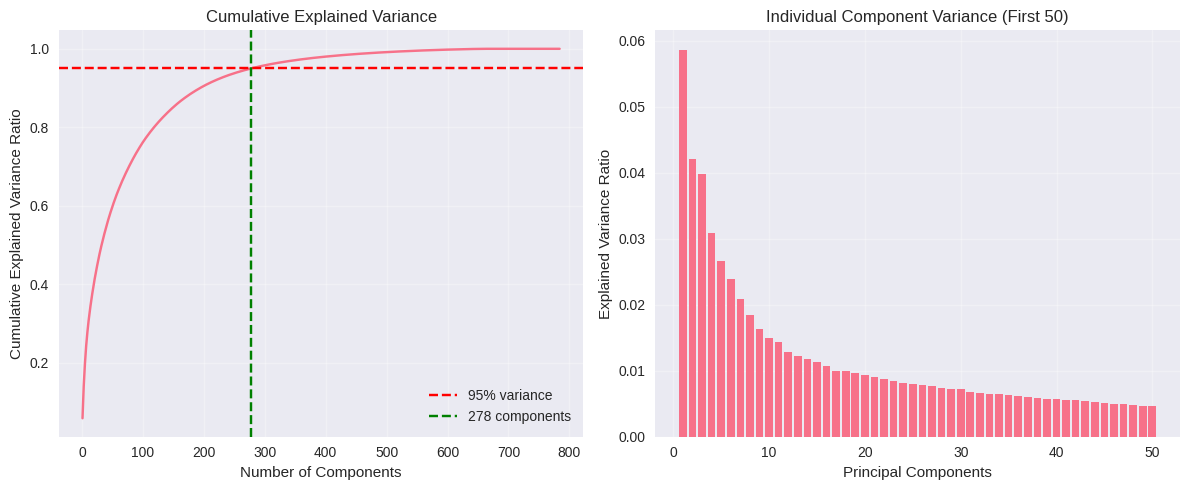

Number of components for 95% variance: 278

3. PCA with 95% variance threshold...
Components selected: 278
Variance explained: 95.01%
Dimensionality reduction: 784 → 278

4. PCA with reconstruction (154 components)...
Reconstruction MSE: 0.1233
Variance explained: 85.68%


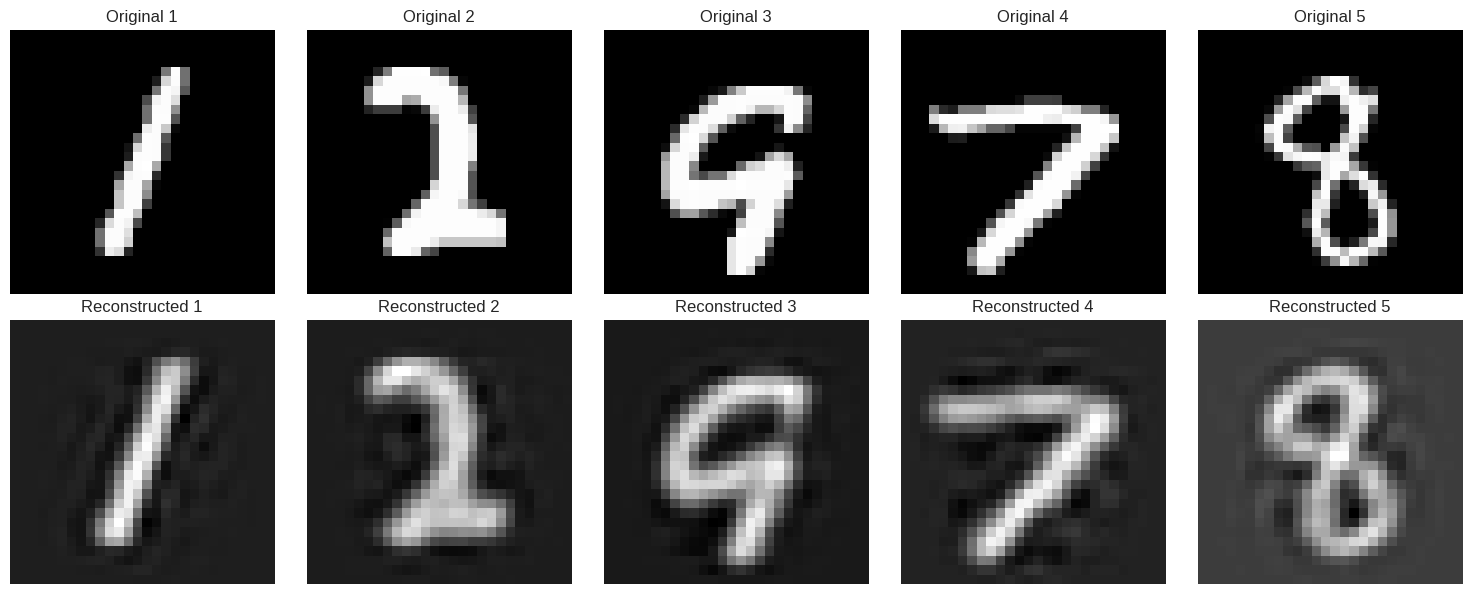


5. Randomized PCA (154 components)...
Training time: 1.88 seconds
Variance explained: 85.55%

6. Incremental PCA (154 components, 10 batches)...
Variance explained: 85.23%

7. Kernel PCA (RBF kernel)...


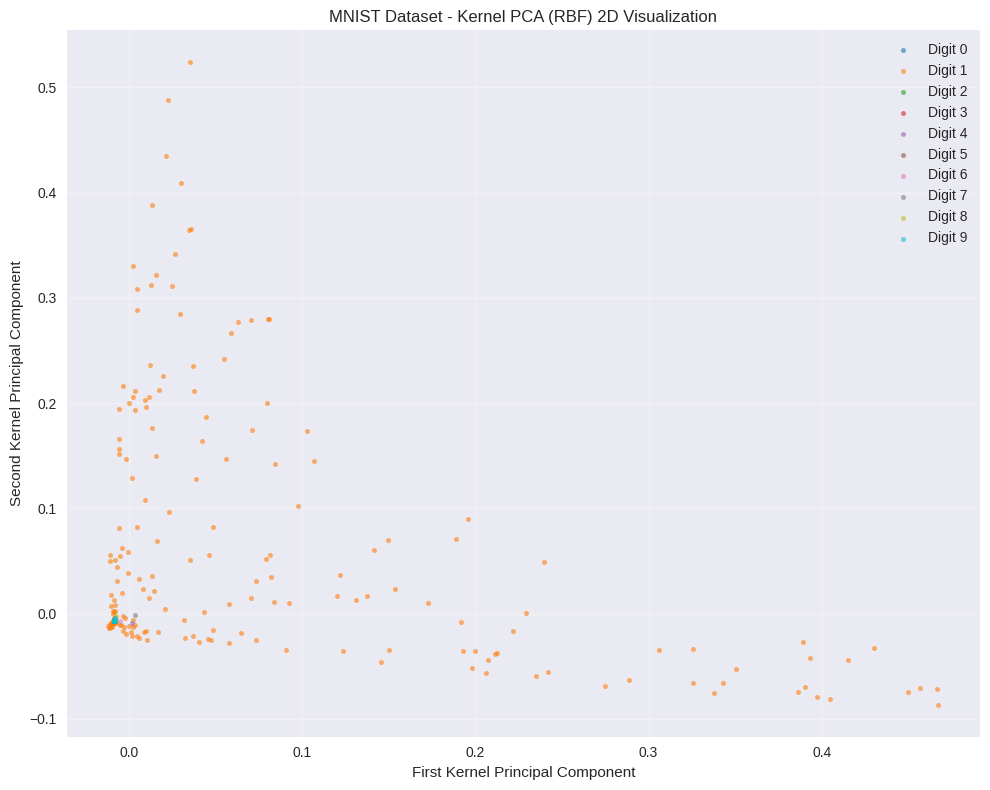


8. Kernel PCA with Grid Search...
Performing Grid Search...
Best parameters: {'kpca__gamma': np.float64(0.03), 'kpca__kernel': 'sigmoid'}
Best cross-validation score: 0.3470

9. Kernel PCA with pre-image reconstruction...
Pre-image reconstruction MSE: 0.8494

10. Locally Linear Embedding...


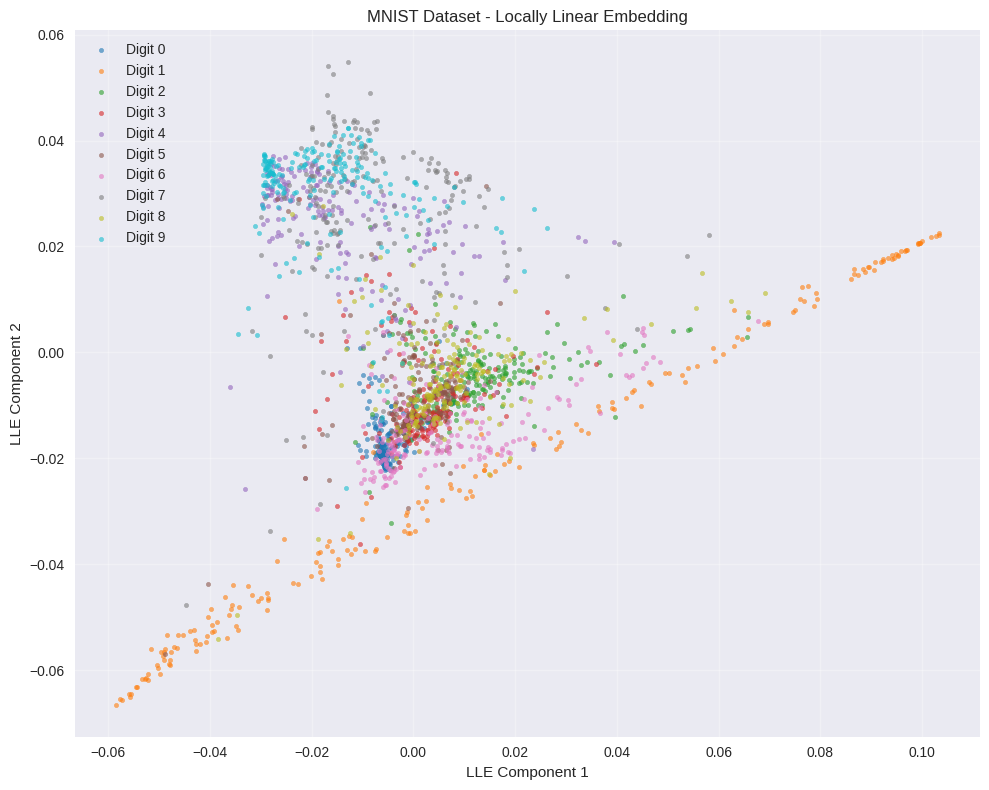

Reconstruction error: 0.0003

11. Comparing different dimensionality reduction methods...
Computing PCA...
Computing Kernel PCA (RBF)...
Computing LLE...


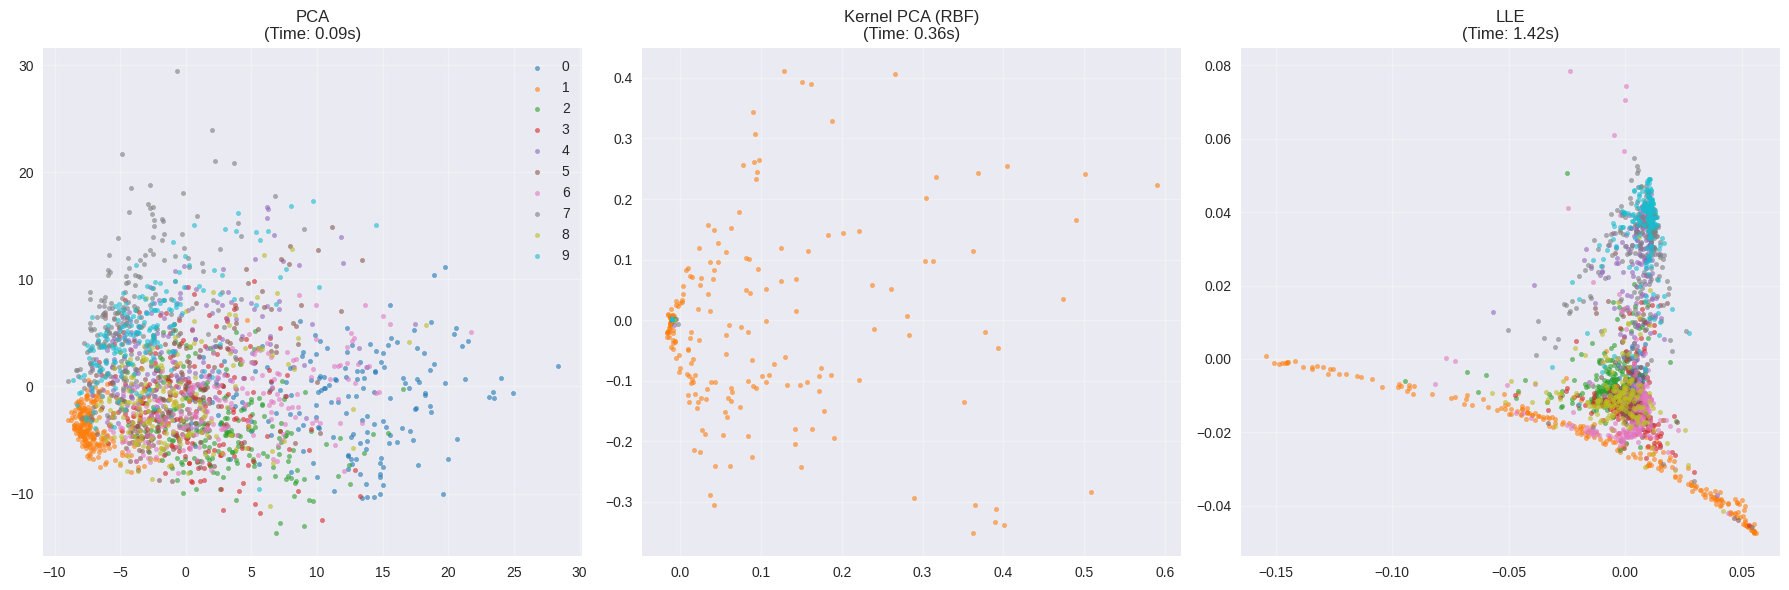


12. Evaluating classification performance...
Testing with 50 components...
Accuracy with 50 components: 0.9020
Testing with 100 components...
Accuracy with 100 components: 0.9025
Testing with 150 components...
Accuracy with 150 components: 0.9015
Testing with 200 components...
Accuracy with 200 components: 0.8995
Testing with 300 components...
Accuracy with 300 components: 0.8930


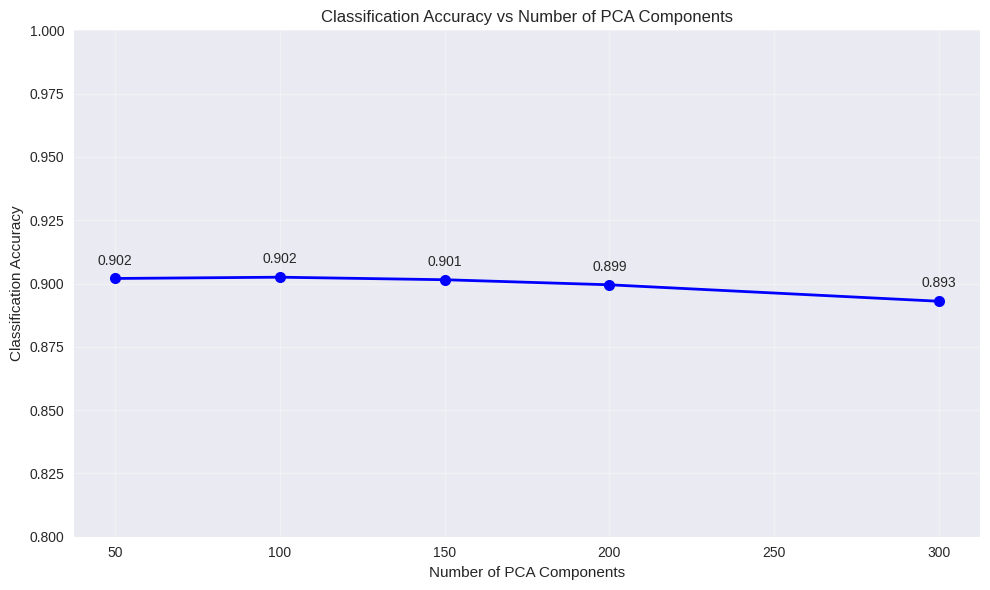


Analysis completed!


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import time
import warnings
warnings.filterwarnings('ignore')

class MNISTDimensionalityReduction:
    def __init__(self):
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()

    def load_data(self, sample_size=10000):
        """Load MNIST dataset"""
        print("Loading MNIST dataset...")
        mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
        X, y = mnist.data, mnist.target.astype(int)

        # Ambil sample untuk efisiensi
        if sample_size < len(X):
            indices = np.random.choice(len(X), sample_size, replace=False)
            X, y = X[indices], y[indices]

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Normalisasi data
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)

        print(f"Data loaded: {self.X_train.shape[0]} training samples, {self.X_test.shape[0]} test samples")
        print(f"Original dimensions: {self.X_train.shape[1]}")

    def standard_pca_2d(self):
        """PCA untuk visualisasi 2D"""
        print("\n1. Standard PCA (2D visualization)...")
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(self.X_train)

        # Visualisasi
        plt.figure(figsize=(10, 8))
        colors = plt.cm.tab10(np.linspace(0, 1, 10))
        for i in range(10):
            mask = self.y_train == i
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1], c=[colors[i]],
                       label=f'Digit {i}', alpha=0.6, s=10)

        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.title('MNIST Dataset - PCA 2D Visualization')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
        print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

        return X_2d, pca

    def find_optimal_components(self):
        """Cari jumlah komponen optimal untuk 95% variance"""
        print("\n2. Finding optimal number of components for 95% variance...")
        pca = PCA()
        pca.fit(self.X_train)

        cumsum = np.cumsum(pca.explained_variance_ratio_)
        d = np.argmax(cumsum >= 0.95) + 1

        # Plot explained variance
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(cumsum) + 1), cumsum)
        plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
        plt.axvline(x=d, color='g', linestyle='--', label=f'{d} components')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title('Cumulative Explained Variance')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.bar(range(1, min(51, len(pca.explained_variance_ratio_) + 1)),
                pca.explained_variance_ratio_[:50])
        plt.xlabel('Principal Components')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Individual Component Variance (First 50)')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"Number of components for 95% variance: {d}")

        return d

    def pca_with_variance_threshold(self):
        """PCA dengan threshold variance 95%"""
        print("\n3. PCA with 95% variance threshold...")
        pca = PCA(n_components=0.95)
        X_reduced = pca.fit_transform(self.X_train)

        print(f"Components selected: {pca.n_components_}")
        print(f"Variance explained: {pca.explained_variance_ratio_.sum():.2%}")
        print(f"Dimensionality reduction: {self.X_train.shape[1]} → {X_reduced.shape[1]}")

        return X_reduced, pca

    def pca_with_reconstruction(self, n_components=154):
        """PCA dengan reconstruction"""
        print(f"\n4. PCA with reconstruction ({n_components} components)...")
        pca = PCA(n_components=n_components)
        X_reduced = pca.fit_transform(self.X_train)
        X_recovered = pca.inverse_transform(X_reduced)

        # Hitung reconstruction error
        mse = np.mean((self.X_train - X_recovered) ** 2)
        print(f"Reconstruction MSE: {mse:.4f}")
        print(f"Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

        # Visualisasi beberapa digit asli vs reconstructed
        self.visualize_reconstruction(self.X_train, X_recovered, n_samples=5)

        return X_reduced, X_recovered, pca

    def randomized_pca(self, n_components=154):
        """Randomized PCA untuk dataset besar"""
        print(f"\n5. Randomized PCA ({n_components} components)...")
        start_time = time.time()

        rnd_pca = PCA(n_components=n_components, svd_solver="randomized", random_state=42)
        X_reduced = rnd_pca.fit_transform(self.X_train)

        end_time = time.time()
        print(f"Training time: {end_time - start_time:.2f} seconds")
        print(f"Variance explained: {rnd_pca.explained_variance_ratio_.sum():.2%}")

        return X_reduced, rnd_pca

    def incremental_pca(self, n_components=154, n_batches=10):
        """Incremental PCA untuk memory efficiency"""
        print(f"\n6. Incremental PCA ({n_components} components, {n_batches} batches)...")

        inc_pca = IncrementalPCA(n_components=n_components)

        # Fit menggunakan batches
        for X_batch in np.array_split(self.X_train, n_batches):
            inc_pca.partial_fit(X_batch)

        # Transform seluruh data
        X_reduced = inc_pca.transform(self.X_train)

        print(f"Variance explained: {inc_pca.explained_variance_ratio_.sum():.2%}")

        return X_reduced, inc_pca

    def kernel_pca_basic(self):
        """Basic Kernel PCA dengan RBF kernel"""
        print("\n7. Kernel PCA (RBF kernel)...")

        # Gunakan subset kecil untuk efisiensi
        subset_size = min(2000, len(self.X_train))
        indices = np.random.choice(len(self.X_train), subset_size, replace=False)
        X_subset = self.X_train[indices]

        rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
        X_reduced = rbf_pca.fit_transform(X_subset)

        # Visualisasi
        plt.figure(figsize=(10, 8))
        colors = plt.cm.tab10(np.linspace(0, 1, 10))
        for i in range(10):
            mask = self.y_train[indices] == i
            if np.any(mask):
                plt.scatter(X_reduced[mask, 0], X_reduced[mask, 1], c=[colors[i]],
                           label=f'Digit {i}', alpha=0.6, s=10)

        plt.xlabel('First Kernel Principal Component')
        plt.ylabel('Second Kernel Principal Component')
        plt.title('MNIST Dataset - Kernel PCA (RBF) 2D Visualization')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return X_reduced, rbf_pca

    def kernel_pca_with_gridsearch(self):
        """Kernel PCA dengan Grid Search untuk parameter optimal"""
        print("\n8. Kernel PCA with Grid Search...")

        # Gunakan subset kecil untuk grid search
        subset_size = min(1000, len(self.X_train))
        indices = np.random.choice(len(self.X_train), subset_size, replace=False)
        X_subset = self.X_train[indices]
        y_subset = self.y_train[indices]

        # Pipeline dengan Kernel PCA dan Logistic Regression
        clf = Pipeline([
            ("kpca", KernelPCA(n_components=2, random_state=42)),
            ("log_reg", LogisticRegression(random_state=42, max_iter=1000))
        ])

        param_grid = [{
            "kpca__gamma": np.linspace(0.03, 0.05, 5),
            "kpca__kernel": ["rbf", "sigmoid"]
        }]

        print("Performing Grid Search...")
        grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_subset, y_subset)

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        return grid_search.best_estimator_, grid_search.best_params_

    def kernel_pca_with_preimage(self):
        """Kernel PCA dengan pre-image reconstruction"""
        print("\n9. Kernel PCA with pre-image reconstruction...")

        # Gunakan subset kecil
        subset_size = min(1000, len(self.X_train))
        indices = np.random.choice(len(self.X_train), subset_size, replace=False)
        X_subset = self.X_train[indices]

        rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                           fit_inverse_transform=True, random_state=42)
        X_reduced = rbf_pca.fit_transform(X_subset)
        X_preimage = rbf_pca.inverse_transform(X_reduced)

        # Hitung reconstruction error
        mse = np.mean((X_subset - X_preimage) ** 2)
        print(f"Pre-image reconstruction MSE: {mse:.4f}")

        return X_reduced, X_preimage, rbf_pca

    def locally_linear_embedding(self):
        """Locally Linear Embedding"""
        print("\n10. Locally Linear Embedding...")

        # Gunakan subset untuk efisiensi
        subset_size = min(2000, len(self.X_train))
        indices = np.random.choice(len(self.X_train), subset_size, replace=False)
        X_subset = self.X_train[indices]

        lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
        X_reduced = lle.fit_transform(X_subset)

        # Visualisasi
        plt.figure(figsize=(10, 8))
        colors = plt.cm.tab10(np.linspace(0, 1, 10))
        for i in range(10):
            mask = self.y_train[indices] == i
            if np.any(mask):
                plt.scatter(X_reduced[mask, 0], X_reduced[mask, 1], c=[colors[i]],
                           label=f'Digit {i}', alpha=0.6, s=10)

        plt.xlabel('LLE Component 1')
        plt.ylabel('LLE Component 2')
        plt.title('MNIST Dataset - Locally Linear Embedding')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"Reconstruction error: {lle.reconstruction_error_:.4f}")

        return X_reduced, lle

    def compare_methods(self):
        """Bandingkan berbagai metode dimensionality reduction"""
        print("\n11. Comparing different dimensionality reduction methods...")

        # Gunakan subset untuk perbandingan
        subset_size = min(2000, len(self.X_train))
        indices = np.random.choice(len(self.X_train), subset_size, replace=False)
        X_subset = self.X_train[indices]
        y_subset = self.y_train[indices]

        methods = {
            'PCA': PCA(n_components=2, random_state=42),
            'Kernel PCA (RBF)': KernelPCA(n_components=2, kernel='rbf', gamma=0.04, random_state=42),
            'LLE': LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
        }

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        colors = plt.cm.tab10(np.linspace(0, 1, 10))

        for idx, (name, method) in enumerate(methods.items()):
            print(f"Computing {name}...")
            start_time = time.time()
            X_reduced = method.fit_transform(X_subset)
            end_time = time.time()

            for i in range(10):
                mask = y_subset == i
                if np.any(mask):
                    axes[idx].scatter(X_reduced[mask, 0], X_reduced[mask, 1],
                                    c=[colors[i]], label=f'{i}', alpha=0.6, s=10)

            axes[idx].set_title(f'{name}\n(Time: {end_time-start_time:.2f}s)')
            axes[idx].grid(True, alpha=0.3)
            if idx == 0:
                axes[idx].legend()

        plt.tight_layout()
        plt.show()

    def evaluate_classification_performance(self):
        """Evaluasi performa klasifikasi dengan berbagai dimensi"""
        print("\n12. Evaluating classification performance...")

        dimensions = [50, 100, 150, 200, 300]
        accuracies = []

        for n_comp in dimensions:
            print(f"Testing with {n_comp} components...")

            # PCA reduction
            pca = PCA(n_components=n_comp, random_state=42)
            X_train_reduced = pca.fit_transform(self.X_train)
            X_test_reduced = pca.transform(self.X_test)

            # Train classifier
            clf = LogisticRegression(random_state=42, max_iter=1000)
            clf.fit(X_train_reduced, self.y_train)

            # Predict and evaluate
            y_pred = clf.predict(X_test_reduced)
            accuracy = accuracy_score(self.y_test, y_pred)
            accuracies.append(accuracy)

            print(f"Accuracy with {n_comp} components: {accuracy:.4f}")

        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(dimensions, accuracies, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Number of PCA Components')
        plt.ylabel('Classification Accuracy')
        plt.title('Classification Accuracy vs Number of PCA Components')
        plt.grid(True, alpha=0.3)
        plt.ylim(0.8, 1.0)

        for i, (dim, acc) in enumerate(zip(dimensions, accuracies)):
            plt.annotate(f'{acc:.3f}', (dim, acc), textcoords="offset points",
                        xytext=(0,10), ha='center')

        plt.tight_layout()
        plt.show()

        return dimensions, accuracies

    def visualize_reconstruction(self, original, reconstructed, n_samples=5):
        """Visualisasi perbandingan data asli vs reconstructed"""
        fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))

        # Denormalisasi untuk visualisasi
        original_denorm = self.scaler.inverse_transform(original)
        reconstructed_denorm = self.scaler.inverse_transform(reconstructed)

        for i in range(n_samples):
            # Original
            axes[0, i].imshow(original_denorm[i].reshape(28, 28), cmap='gray')
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')

            # Reconstructed
            axes[1, i].imshow(reconstructed_denorm[i].reshape(28, 28), cmap='gray')
            axes[1, i].set_title(f'Reconstructed {i+1}')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    def run_all_methods(self):
        """Jalankan semua metode dimensionality reduction"""
        print("Starting comprehensive MNIST dimensionality reduction analysis...")
        print("=" * 60)

        # Load data
        self.load_data(sample_size=10000)

        # 1. Standard PCA 2D
        self.standard_pca_2d()

        # 2. Find optimal components
        optimal_components = self.find_optimal_components()

        # 3. PCA with variance threshold
        self.pca_with_variance_threshold()

        # 4. PCA with reconstruction
        self.pca_with_reconstruction(n_components=min(154, optimal_components))

        # 5. Randomized PCA
        self.randomized_pca(n_components=min(154, optimal_components))

        # 6. Incremental PCA
        self.incremental_pca(n_components=min(154, optimal_components))

        # 7. Kernel PCA basic
        self.kernel_pca_basic()

        # 8. Kernel PCA with Grid Search
        self.kernel_pca_with_gridsearch()

        # 9. Kernel PCA with pre-image
        self.kernel_pca_with_preimage()

        # 10. Locally Linear Embedding
        self.locally_linear_embedding()

        # 11. Compare methods
        self.compare_methods()

        # 12. Evaluate classification performance
        self.evaluate_classification_performance()

        print("\nAnalysis completed!")
        print("=" * 60)

# Example usage
if __name__ == "__main__":
    # Inisialisasi dan jalankan semua metode
    mnist_dr = MNISTDimensionalityReduction()
    mnist_dr.run_all_methods()

    # Atau jalankan metode individual
    # mnist_dr.load_data(sample_size=5000)
    # mnist_dr.standard_pca_2d()
    # mnist_dr.kernel_pca_basic()